In [1]:
import pandas as pd
import matplotlib.pylab as plt
import itertools
from statsmodels.graphics.tsaplots import plot_predict
import numpy as np
from pyspark.sql import SparkSession
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import plotly
import plotly.graph_objects as go
from itertools import cycle
from sklearn.model_selection import TimeSeriesSplit
from pmdarima.arima import ADFTest
from pmdarima.arima import auto_arima
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=60,center=False).mean() 
    rolstd = timeseries.rolling(window=60,center=False).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [9]:
def standardising_data(train, test):
    scaler = StandardScaler()
    scaler.fit(train['cnt'].values.reshape(-1, 1))
    train['stand_value'] = scaler.transform(train['cnt'].values.reshape(-1, 1))
    test['stand_value'] = scaler.transform(test['cnt'].values.reshape(-1, 1))
    train = train.drop(columns=['cnt'], axis=1)
    test = test.drop(columns=['cnt'], axis=1)
    return train, test

In [28]:
path = "tsData.json"
dataset = pd.read_json(path)

In [29]:
dataset.index = pd.to_datetime(dataset.index)

In [30]:
df =  pd.DataFrame(dataset.cnt.resample("5MIN", base=1).sum())

In [6]:
print(df.info())
print(df.shape)
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1729 entries, 2022-03-20 02:56:00 to 2022-03-26 02:56:00
Freq: 5T
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cnt     1729 non-null   int64
dtypes: int64(1)
memory usage: 27.0 KB
None
(1729, 1)
                cnt
count  1.729000e+03
mean   8.836529e+05
std    3.800296e+05
min    1.244250e+05
25%    6.957280e+05
50%    7.812090e+05
75%    1.105356e+06
max    3.308481e+06
                        cnt
2022-03-20 02:56:00  126077
2022-03-20 03:01:00  646378
2022-03-20 03:06:00  616458
2022-03-20 03:11:00  653960
2022-03-20 03:16:00  623906


<AxesSubplot:>

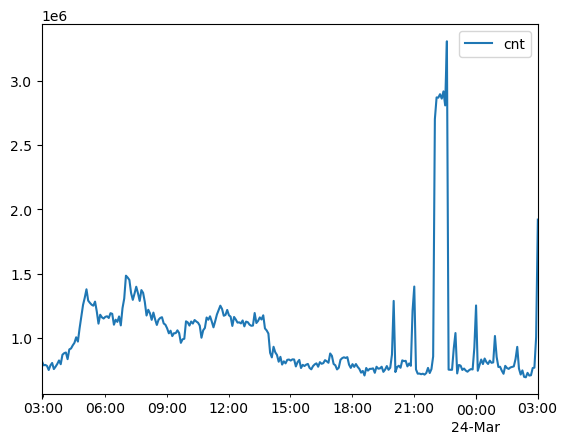

In [7]:
df['2022-03-23 02:56:00':'2022-03-24 03:01:00'].plot() 

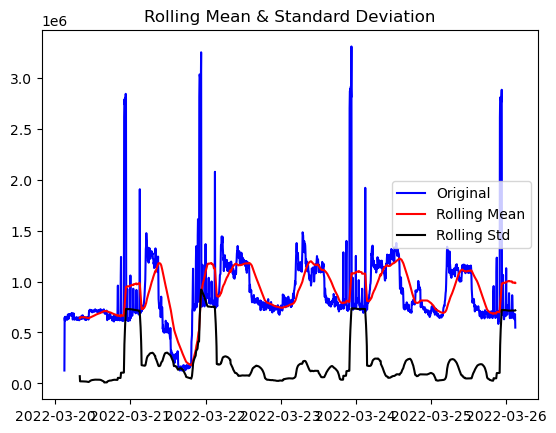

Results of Dickey-Fuller Test:
Test Statistic                   -4.716276
p-value                           0.000078
#Lags Used                       23.000000
Number of Observations Used    1705.000000
Critical Value (1%)              -3.434191
Critical Value (5%)              -2.863237
Critical Value (10%)             -2.567673
dtype: float64


In [8]:
test_stationarity(df)

Text(0, 0.5, 'cnt')

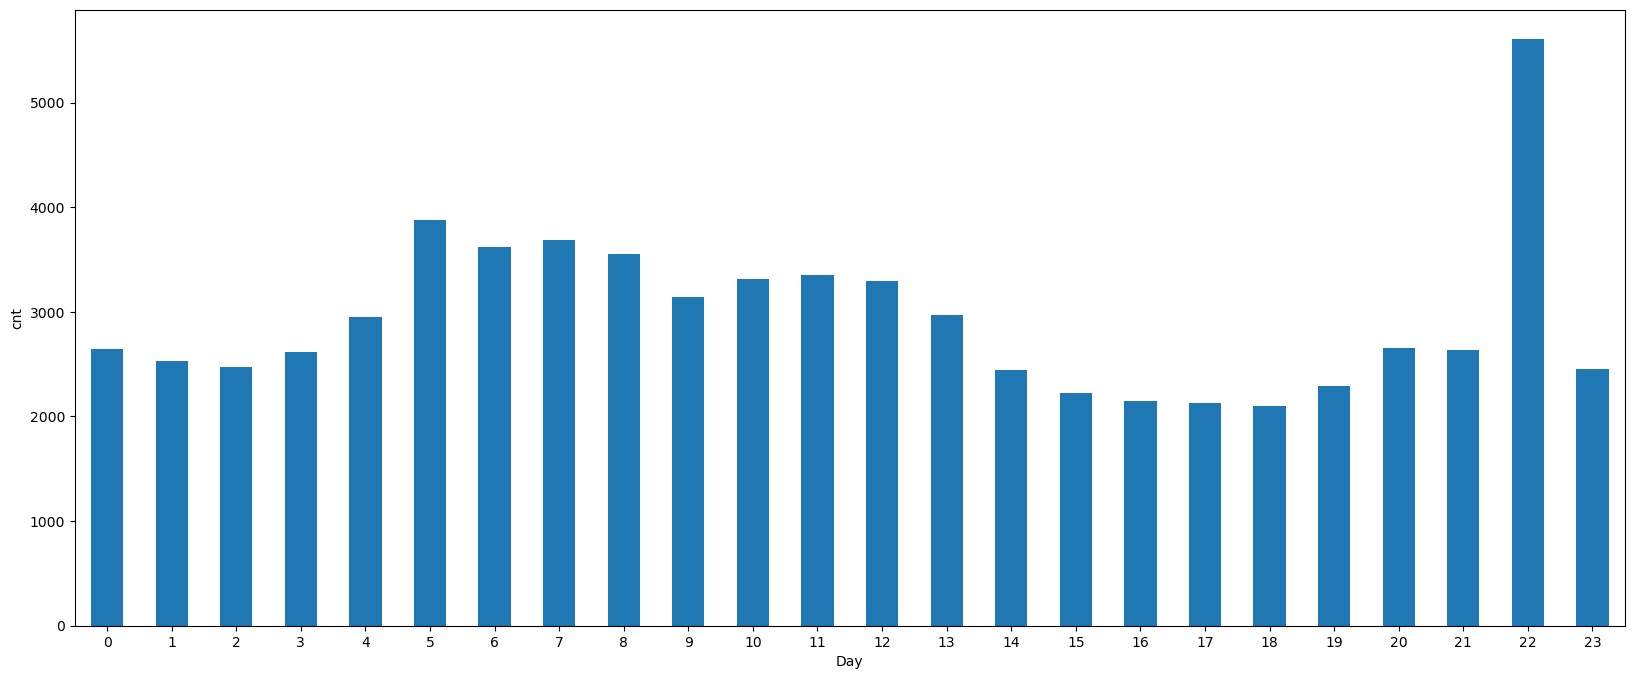

In [32]:
fig, axs = plt.subplots(figsize=(20, 8))
dataset.groupby(
                    dataset.index.hour)["cnt"].mean().plot(kind='bar',
                    rot=0,
                    ax=axs)
plt.xlabel("Day")
plt.ylabel("cnt")

Text(0, 0.5, 'cnt')

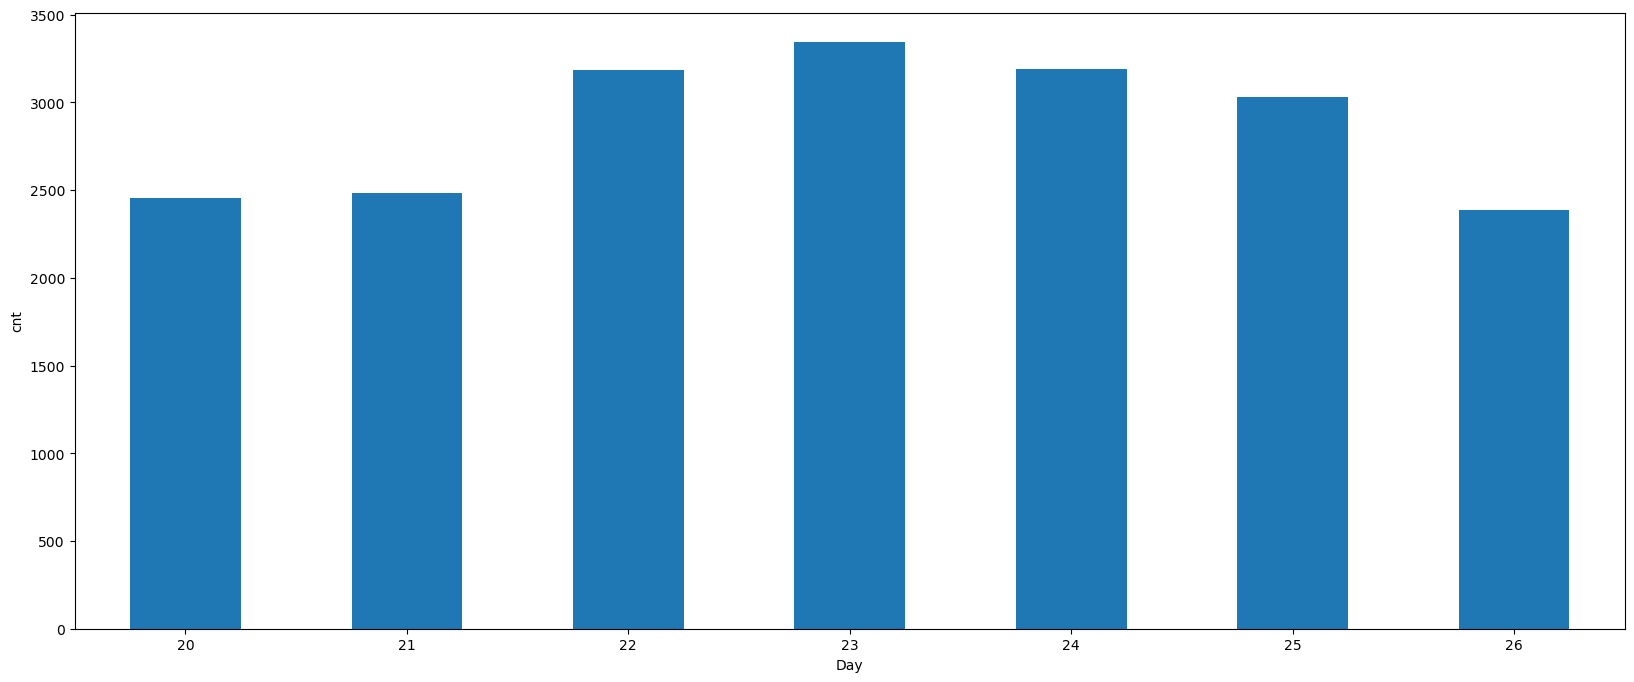

In [11]:
fig, axs = plt.subplots(figsize=(20, 8))
dataset.groupby(
                    dataset.index.day)["cnt"].mean().plot(kind='bar',
                    rot=0,
                    ax=axs)
plt.xlabel("Day")
plt.ylabel("cnt")

<AxesSubplot:>

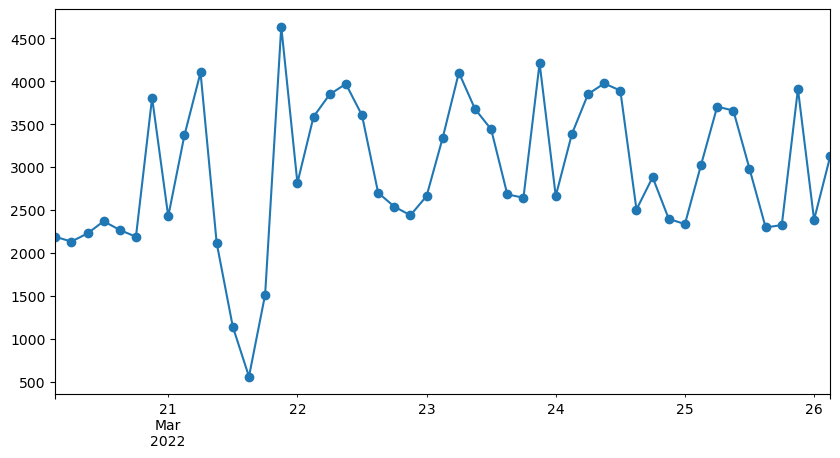

In [15]:
dataset.cnt.resample("3H").mean().plot(style="-o", figsize=(10, 5))

In [33]:
X = df.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split: -1]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=814332.800926, mean2=953362.144676
variance1=164627243280.585388, variance2=114422375715.126053


In [35]:
scaler = StandardScaler()
scaler.fit(df['cnt'].values.reshape(-1, 1))
df['stand_value'] = scaler.transform(df['cnt'].values.reshape(-1, 1))
df = df.drop(columns=['cnt'], axis=1)

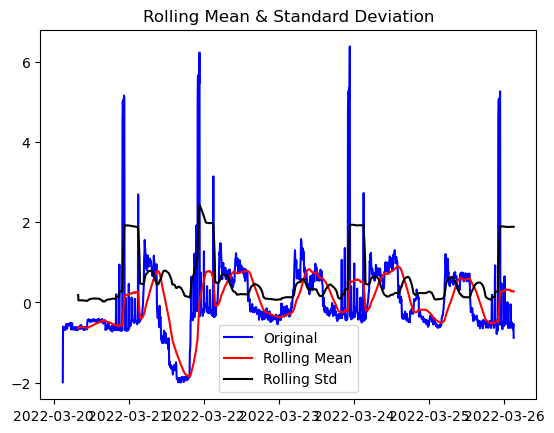

Results of Dickey-Fuller Test:
Test Statistic                   -4.716276
p-value                           0.000078
#Lags Used                       23.000000
Number of Observations Used    1705.000000
Critical Value (1%)              -3.434191
Critical Value (5%)              -2.863237
Critical Value (10%)             -2.567673
dtype: float64


In [47]:
test_stationarity(df)

In [36]:
X = df.values
split = int(len(X) / 2)
X1, X2 = X[0:split], X[split: -1]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.182460, mean2=0.183484
variance1=1.140560, variance2=0.792734


In [34]:
train_set, test_set = np.split(df, [int(.67 *len(df))])
train_set, test_set = standardising_data(train_set, test_set)

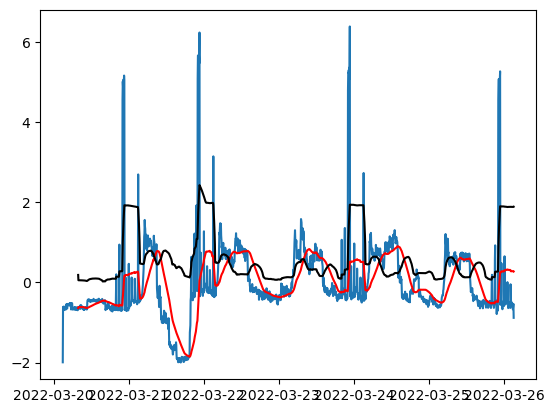

In [48]:
moving_average = df.rolling(window=60).mean()
moving_std =  df.rolling(window=60).std()
plt.plot(df)
plt.plot(moving_average, color='red')
plt.plot(moving_std, color='black')
#still not stationary

In [45]:
stand_value_minus_moving_avg = df - moving_average #try another way to make data stationary
stand_value_minus_moving_avg.dropna(inplace=True)

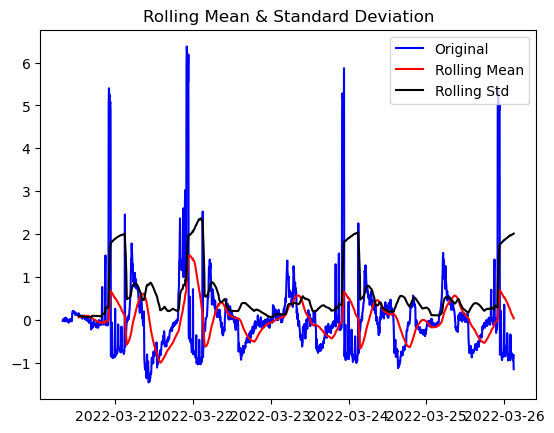

Results of Dickey-Fuller Test:
Test Statistic                -5.871257e+00
p-value                        3.236221e-07
#Lags Used                     2.300000e+01
Number of Observations Used    1.646000e+03
Critical Value (1%)           -3.434329e+00
Critical Value (5%)           -2.863298e+00
Critical Value (10%)          -2.567706e+00
dtype: float64


In [46]:
test_stationarity(stand_value_minus_moving_avg) 

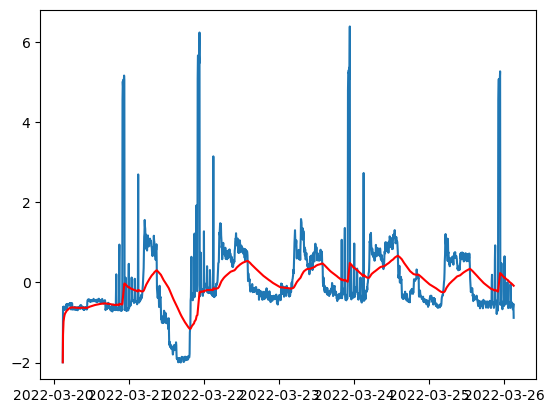

In [49]:
exponentialDecayWeightedAverage = df.ewm(halflife=60, min_periods=0, adjust=True).mean() #вычисляем взвешенное среднее чтобы увидеть тренд который есть во временном ряду
plt.plot(df)
plt.plot(exponentialDecayWeightedAverage, color='red')

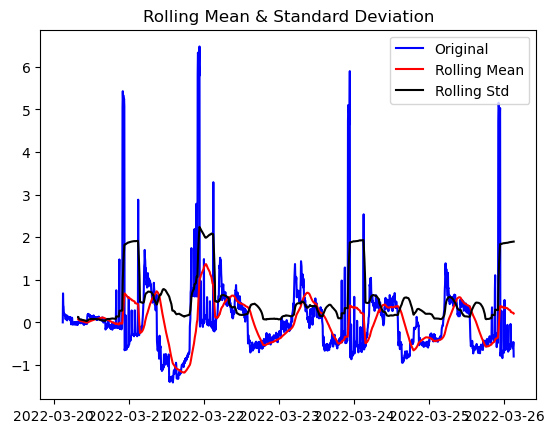

Results of Dickey-Fuller Test:
Test Statistic                   -5.301019
p-value                           0.000005
#Lags Used                       23.000000
Number of Observations Used    1705.000000
Critical Value (1%)              -3.434191
Critical Value (5%)              -2.863237
Critical Value (10%)             -2.567673
dtype: float64


In [50]:
standValueMinusMovingExponentialDecayWeightedAverage = df - exponentialDecayWeightedAverage #еще одна трансформация, на этот раз вычитаем взвешенное среднее чтобы еще раз проверить на стационарность
test_stationarity(standValueMinusMovingExponentialDecayWeightedAverage)

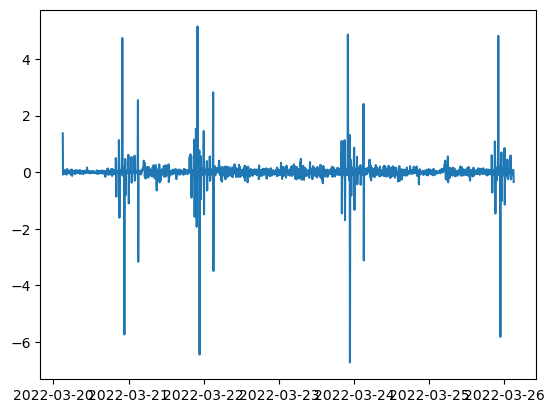

In [52]:
standValueDiffShifting = df - df.shift() #cдвигаем значения на единицу
plt.plot(standValueDiffShifting)

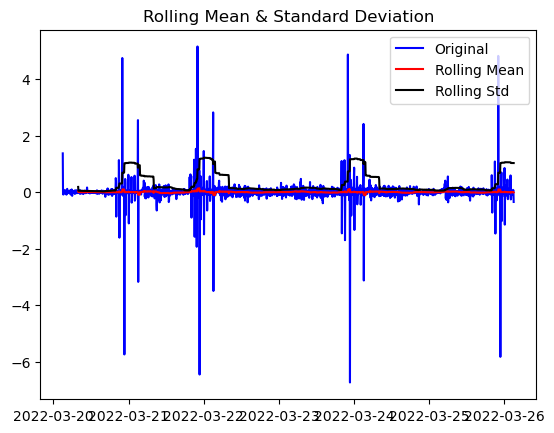

Results of Dickey-Fuller Test:
Test Statistic                -1.281066e+01
p-value                        6.457139e-24
#Lags Used                     2.200000e+01
Number of Observations Used    1.705000e+03
Critical Value (1%)           -3.434191e+00
Critical Value (5%)           -2.863237e+00
Critical Value (10%)          -2.567673e+00
dtype: float64


In [53]:
standValueDiffShifting.dropna(inplace=True)
test_stationarity(standValueDiffShifting) #график с ровной линией скользяцего среднего

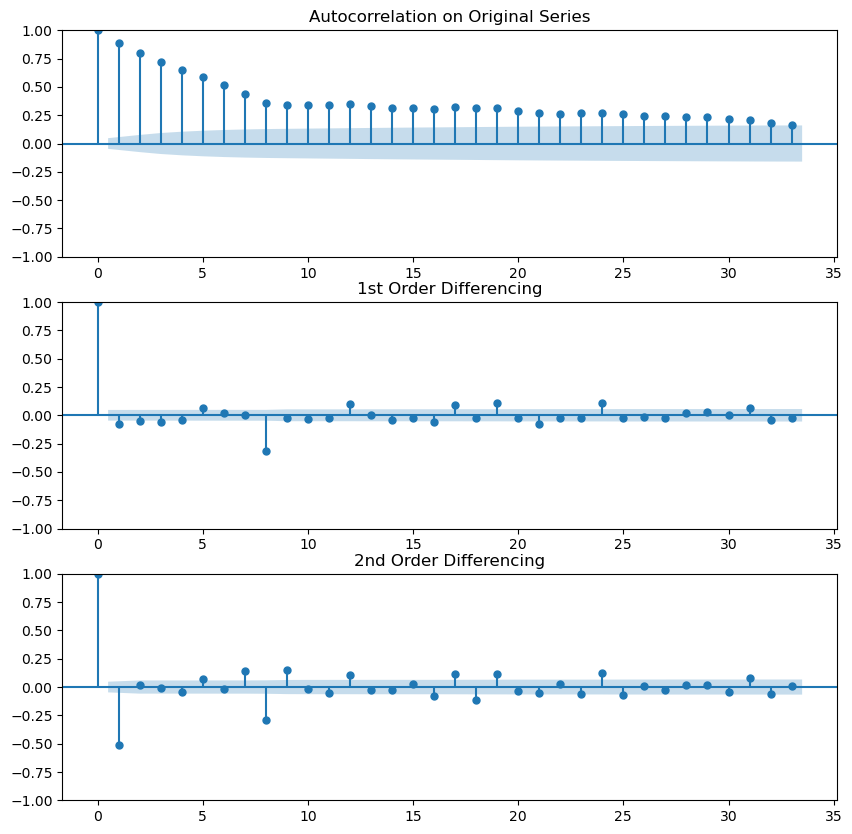

In [86]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(df, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(df.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(df.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")
fig.show()
#значение d будет 1

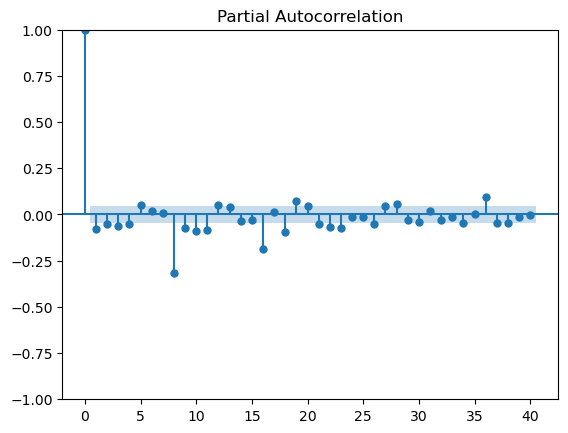

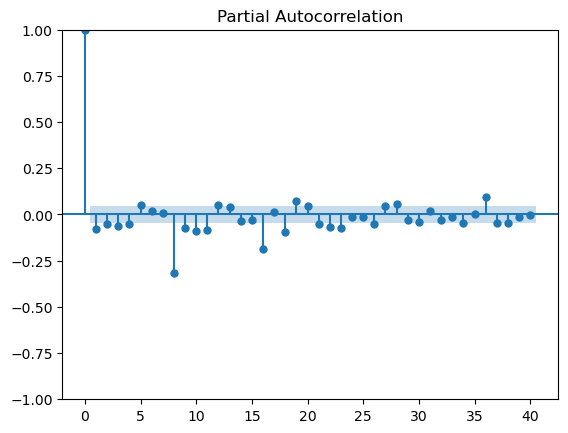

In [87]:
plot_pacf(df.diff().dropna(), lags=40)


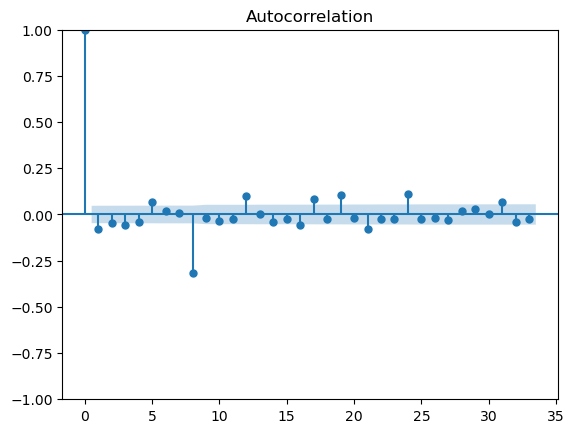

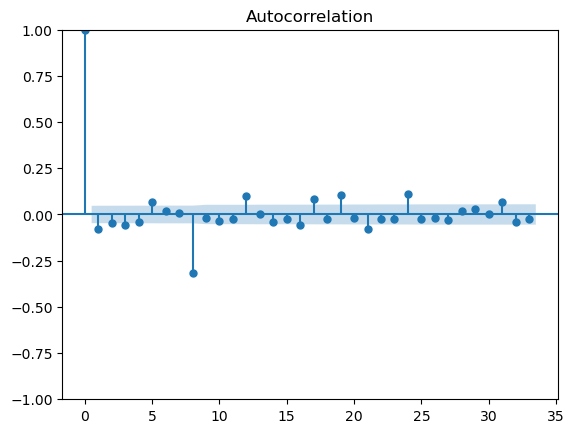

In [85]:
plot_acf(df.diff().dropna())

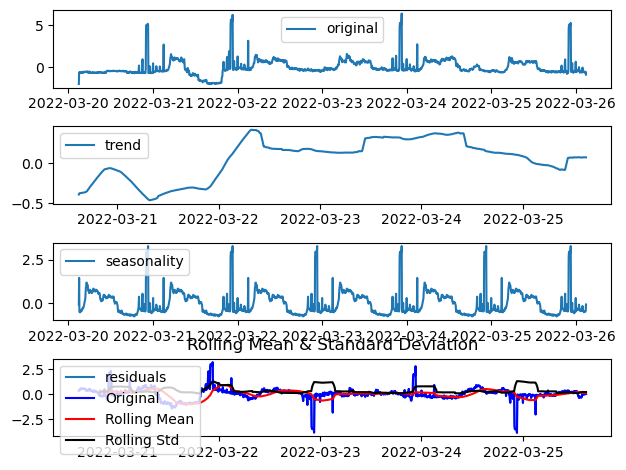

Results of Dickey-Fuller Test:
Test Statistic                   -4.676116
p-value                           0.000093
#Lags Used                       24.000000
Number of Observations Used    1416.000000
Critical Value (1%)              -3.434977
Critical Value (5%)              -2.863583
Critical Value (10%)             -2.567858
dtype: float64


In [54]:
#посмотрим на компоненты временного ряда
decomposition = seasonal_decompose(df, period = 288)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(df, label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='residuals')
plt.legend(loc='best')
plt.tight_layout()



#последний график это неравномерности которые есть во временном ряду, они не имеют порядок размер и не могут помочь в прогнозировании
#посмотрим стационарен ли этот шум
decomposedData = residual
decomposedData.dropna(inplace=True)
test_stationarity(decomposedData)


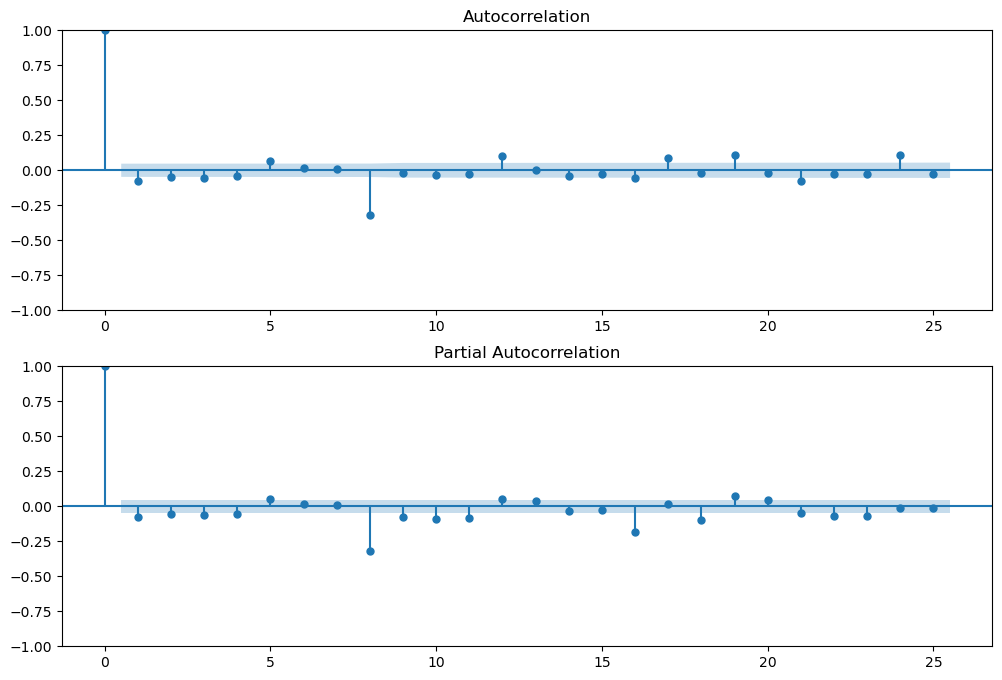

In [79]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(standValueDiffShifting.dropna().values.squeeze(), lags=25, ax=ax1) #q
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(standValueDiffShifting.dropna(), lags=25, ax=ax2) #p
#ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
# PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
# После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля.
# По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций  падают.
# Но p и q могут быть и другие, если более строго рассматривать эти графики

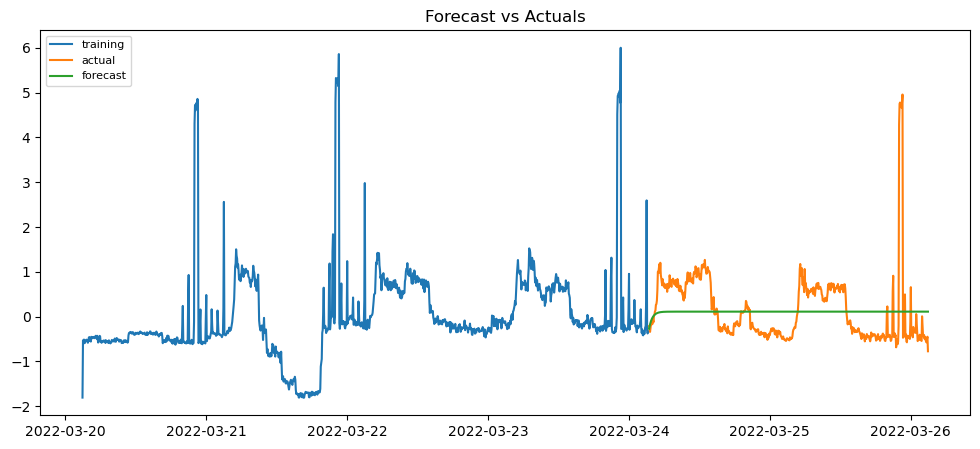

In [56]:
model = ARIMA(train_set, order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(600, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_set.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_set, label='training')
plt.plot(test_set, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [62]:
fitted.summary() #Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            stand_value   No. Observations:                 1158
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -753.179
Date:                Wed, 28 Dec 2022   AIC                           1512.358
Time:                        16:47:28   BIC                           1527.518
Sample:                    03-20-2022   HQIC                          1518.079
                         - 03-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8606      0.016     55.239      0.000       0.830       0.891
ma.L1         -0.9826      0.009   -104.558      0.000      -1.001      -0.964
sigma2         0.2151      0.002    105.990      0.000       0.211       0.219
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):            252213.46
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                            -1.24
Prob(H) (two-sided):                  0.12   Kurtosis:                        75.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

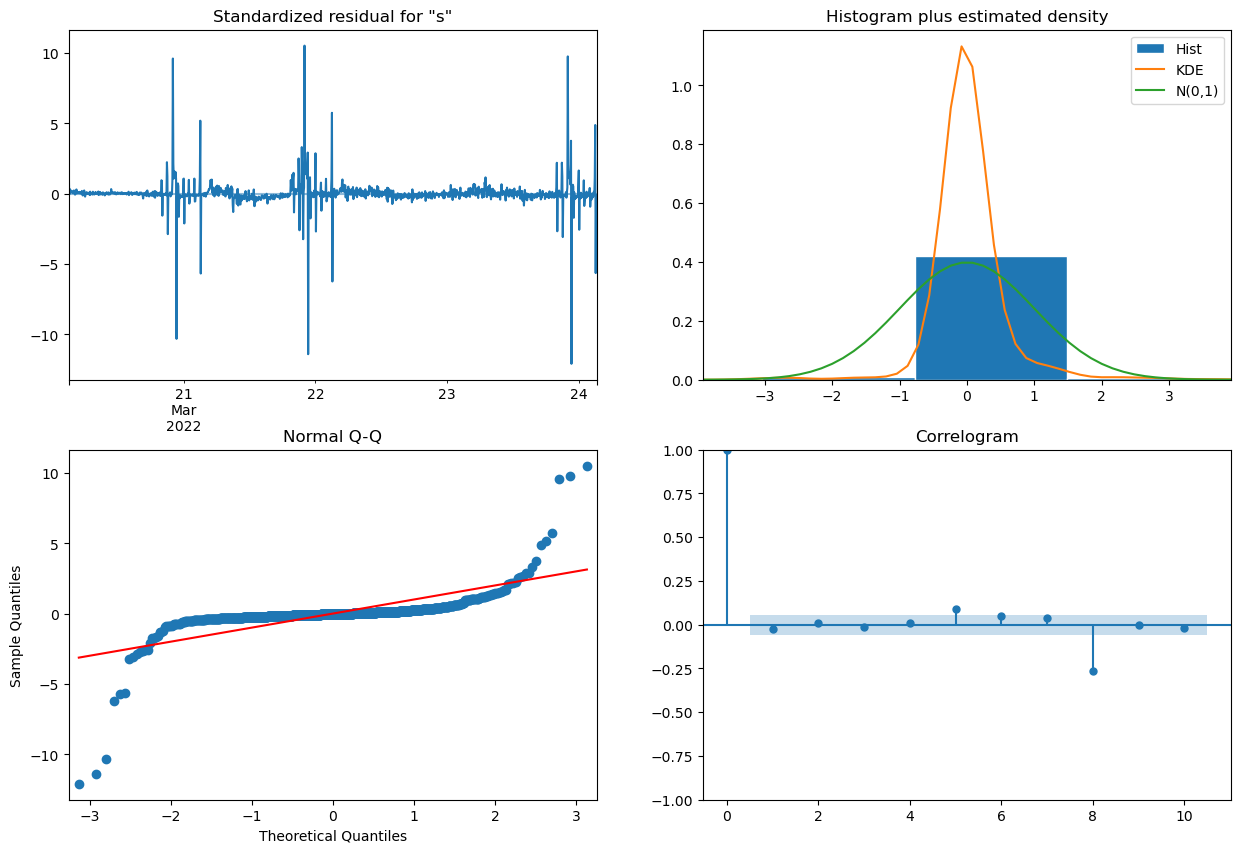

In [70]:
fitted.plot_diagnostics(figsize=(15, 10))
plt.show()

In [90]:
q_test = sm.tsa.stattools.acf(fitted.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print (pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

        Q-stat       p-value
0     1.490536  2.221333e-01
1     1.606714  4.478231e-01
2     1.810507  6.126511e-01
3     1.954568  7.441148e-01
4    10.868407  5.405241e-02
5    13.883160  3.096892e-02
6    15.378297  3.144463e-02
7    93.605087  8.603856e-17
8    93.605972  3.069149e-16
9    94.095076  8.225200e-16
10   94.102635  2.607482e-15
11  106.923257  2.424930e-17
12  107.343817  6.179380e-17
13  108.945478  8.956837e-17
14  109.031623  2.473525e-16
15  110.919020  2.999188e-16
16  121.318614  8.644656e-18
17  121.440209  2.243325e-17
18  135.480469  1.329203e-19
19  135.522404  3.560839e-19
20  139.297223  1.853162e-19
21  139.415148  4.629143e-19
22  139.721164  1.043126e-18
23  155.405671  3.258312e-21
24  155.694920  7.459162e-21
25  155.802862  1.809421e-20
26  155.970974  4.197782e-20
27  156.654088  7.711037e-20
28  158.404951  8.956853e-20
29  158.519722  2.028847e-19
